# Naravni zlepek
##### Andrej Jočić

## Naloga

Danih je $n$ interpolacijskih točk $(x_i,y_i)$ , $i=1,2,...,n$. **Naravni interpolacijski kubični zlepek** $S$ je funkcija, ki izpolnjuje naslednje pogoje:

1. $S(x_i)=y_i, i=1,2,...,n.$

2. $S$ je polinom stopnje 3 ali manj na vsakem podintervalu $[x_i,x_{i+1}]$, $i=1,2,...,n−1$.

3. $S$ je dvakrat zvezno odvedljiva funkcija na interpolacijskem intervalu $[x_1,x_n]$

4. $S^{′′}(x_1)=S^{′′}(x_n)=0$.

Zlepek $S$ določimo tako, da postavimo

$S(x)=S_i(x)=a_i+b_i(x−x_i)+c_i(x−x_i)^2+d_i(x−x_i)^3, x∈[x_i,x_{i+1}]$,

nato pa izpolnimo zahtevane pogoje.




## Rešitev

<!-- Napišite funkcijo `Z = interpoliraj(x, y)`, ki izračuna koeficiente polinoma $S_i$ in vrne element tipa `Zlepek`. -->
Funkcija `S = interpolate(x, y)` izračuna koeficiente polinomov $S_i$ in jih skupaj z vrednostmi $x_i$ zapakira v objekt tipa `CubicSpline`.

Pogoj **1** nam pove $S(x_i) = y_i = S_i(x_i) = a_i$, torej imamo že določene koeficiente $a_i$ $(1 \leq i \leq n-1)$.
Ostane nam še $3 (n - 1)$ neznank, torej rabimo ravno toliko linearnih enačb.

Prvo enačbo dobimo še iz pogoja **1** za $i=n$: $S_{n-1}(x_n) = y_n$.
Pogoj **2** je trivialno izpolnjen z zastavljeno obliko $S_i$, torej iz njega ne dobimo nobene enačbe.

Pogoj **3** je tudi izpoljen za $x \notin \{x_1, \ldots, x_n\}$ (ker so $S_i$ polinomi), moramo ga pa zagotoviti še na vseh $n-2$ stičnih točkah.
Za vsak $i: 1 \leq i \leq n-2$ dobimo 3 pogoje:
- zveznost $S$: $b_i \Delta x_i + c_i \Delta x_i^2 + d_i \Delta x_i^3 = \Delta y_i$
- zveznost $S^\prime$: $b_i + 2 c_i \Delta x_i + 3 d_i \Delta x_i^2 = b_{i+1}$
- zveznost $S^{\prime\prime}$: $c_i + 3 d_i \Delta x_i = c_{i+1}$

kjer $\Delta x_i = x_{i+1} - x_i$ in $\Delta y_i = y_{i+1} - y_i$.

Iz pogoja **4** dobimo še enačbi $c_1 = 0$ in $c_{n-1} + 3d_{n-1} \Delta x_{n-1} = 0$, tako da imamo vse skupaj $1 + 3(n-2) + 2 = 3(n-1)$ enačb.

Ker ima enačba za zveznost $S^\prime$ štiri neznanke, z nobeno permutacijo ne bomo dobili tridiagonalne matrike, torej Thomasov algoritem odpade.
Morda bi ga lahko modificirali za pentadiagonalne matrike, ampak smo raje enostavno uporabili redko matriko.
To se vsekakor splača, ker je delež ne-ničelnih elementov matrike sistema enak
$$
\frac{10n-14}{(3n-3)^2} = O(1/n).
$$
Poglejmo, koliko se matrika napolni pri LU razcepu:

In [1]:
using SplineInterpolation
using Plots, LinearAlgebra

In [ ]:
system_density = (n) -> (10n - 14) / (3n - 3)^2

function posterior_density(n)
    M, _ = ncs_system(collect(1:n), rand(n))
    fac = lu(M)
    L_non0 = count(!iszero, fac.L) - n # don't count the 1s on the diagonal
    U_non0 = count(!iszero, fac.U)
    return (L_non0 + U_non0) / length(M)
end

nvals = 50:50:2000
priors = system_density.(nvals)
posteriors = posterior_density.(nvals)

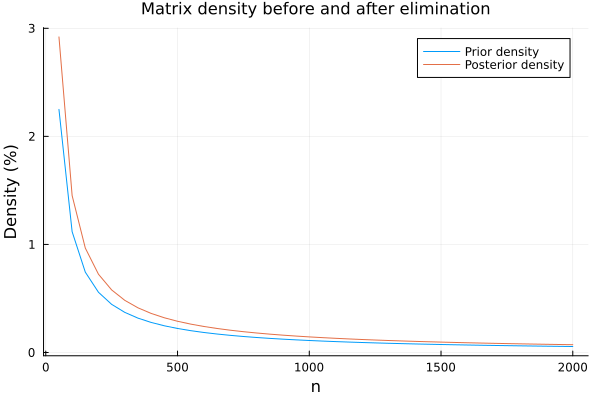

In [3]:
plot(nvals, 100 .* priors, label="Prior density")
plot!(nvals, 100 .* posteriors, label="Posterior density")
title!("Matrix density before and after elimination", titlefont=font(11))
xlabel!("n")
ylabel!("Density (%)")
# plot!(xscale=:log10, yscale=:log10)

Kot vidimo se delež neničelnih elementov bistveno ne poveča pri eliminaciji, tako da je reševanje sistema še vedno približno $O(n)$.


<!-- Tip `Zlepek` definirajte sami in naj vsebuje koeficiente polinoma in interpolacijske točke. Za tip `Zlepek` napišite dve funkciji -->

<!-- - `y = vrednost(Z, x)`, ki vrne vrednost zlepka v dani točki $x$. -->

Funkcija `y = evaluate(cs::CubicSpline, x)` vrne vrednost zlepka v dani točki $x \in [x_1, x_n]$.
Najprej je treba z bisekcijo najti interval, v katerem se $x$ nahaja, nato pa samo evalviramo pripadajoči polinom tretje stopnje. Evalvacija za eno točko torej traja $O(\log n)$.

## Primer uporabe

Poskusimo interpolirati slavni *Rungejev protiprimer* na ekvidistančnih točkah.

In [4]:
runge = (x) -> 1 / (1 + x^2)
bounds = -10:10
nsamples = 15 # number of (equidistant) points to interpolate over

x = range(bounds[1], bounds[end], length = nsamples)
y = runge.(x)

spl = interpolate(x, y)

SplineInterpolation.CubicSpline([-10.0, -8.571428571428571, -7.142857142857143, -5.714285714285714, -4.285714285714286, -2.857142857142857, -1.4285714285714286, 0.0, 1.4285714285714286, 2.857142857142857, 4.285714285714286, 5.714285714285714, 7.142857142857143, 8.571428571428571, 10.0], [0.009900990099009901, 0.013428336530556318, 0.019223224794036875, 0.02971497877501516, 0.05163329820864068, 0.1091314031180401, 0.32885906040268453, 1.0, 0.32885906040268453, 0.1091314031180401, 0.05163329820864068, 0.02971497877501516, 0.019223224794036875, 0.013428336530556318, 0.009900990099009901], [0.0023152972442672007, 0.002776833017713074, 0.00615406354443715, 0.006808861517901889, 0.034671644554623286, 0.021279051383957328, 0.4623862505170397, -2.8779033967690207e-16, -0.4623862505170393, -0.021279051383957463, -0.03467164455462324, -0.0068088615179018935, -0.0061540635444371486, -0.002776833017713077], [0.0, 0.0003230750414121112, 0.0020409863272947463, -0.0015826277458694349, 0.0210865758715

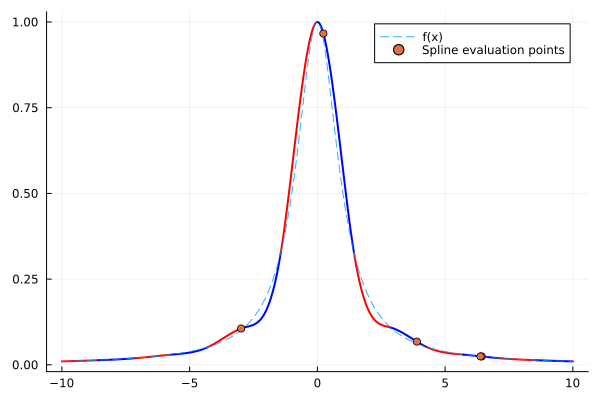

In [5]:
plot()
plot_spline(spl; lw=2)
plot!(runge, bounds[1], bounds[end], label="f(x)", linestyle=:dash, alpha=0.8, lw=1)

xs = bounds[1] .+ (bounds[end] - bounds[1]) * rand(5)
scatter!(xs, spl.(xs), label="Spline evaluation points")

Poglejmo še numerično napako aproksimacije:

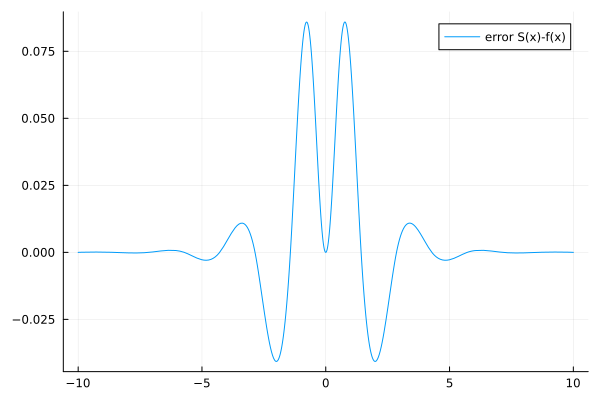

In [6]:
plot(val->spl(val)-runge(val), bounds[1], bounds[end], label="error S(x)-f(x)")